 # Brand Sentiment Analysis of Twitter Posts

 ## Setup

In [1]:
# STANDARD IMPORTS
import os
import json

In [2]:
# INSTALL REQUIRED PACKAGES FOR PROJECT
PACKAGES = [
    "matplotlib",
    "nltk",
    "numpy",
    "openai",
    "pandas",
    "python-dotenv",
    "seaborn",
    "sklearn",
    "tensorflow",
    "torch",
    "transformers",
    "tweet-preprocessor",
    "wandb",
]


def handle_packages(package: str) -> None:
    """Quietly installs a package if it is not already installed.

    Args:
        package (str): The name of the package to install.

    Raises:
        ImportError: If the package is not installed, install it.
    """
    try:
        __import__(package)
    except ImportError:
        os.system(f"pip install -q {package}")


for package in PACKAGES:
    handle_packages(package=package)

2023-07-30 23:23:07.593823: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-30 23:23:07.717416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 23:23:08.781541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/anaconda3/envs/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_t

In [3]:
# STANDARD DATA MANIPULATION/VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# CONFIGURE
pd.set_option("display.max_colwidth", 80)

In [4]:
# LOAD ENVIRONMENT VARIABLES
import dotenv

ENVIRONMENT = dotenv.dotenv_values()
for key in ENVIRONMENT:
    os.environ[key] = ENVIRONMENT[key]

 ## Exploratory Data Analysis (EDA)

 ### Sentiment140 Dataset

 Sentiment140 is a dataset containing 1.6 million tweets with sentiment labels.
 It allows you to discover the sentiment of a brand, product, or topic on Twitter.
 The data is a CSV with emoticons removed.

In [5]:
# PULL TRAINING DATASET FROM GIT LFS
!git lfs pull -I "datasets/training.1600000.processed.noemoticon.csv"

df_train = pd.read_csv(
    "datasets/training.1600000.processed.noemoticon.csv",
    encoding="ISO-8859-1",
    names=["target", "ids", "date", "flag", "user", "text"],
    header=None,
)

The dataset has 6 fields:

1. `target` — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1. `id` — the id of the tweet (2087)
1. `date` — the date of the tweet (Sat May 16 23:58:44 UTC 2009)
1. `flag` — the query (lyx). If there is no query, then this value is NO_QUERY.
1. `user` — the user that tweeted (robotickilldozr)
1. `text` — the text of the tweet (Lyx is cool)

 ### Class Balance

 We show that the dataset is balanced by counting the number of positive and negative tweets.

 Balance is important because it means that the model will be trained on an equal number of positive and negative tweets.
 If the dataset was imbalanced, then the model would be trained on more of one class than the other.
 This would result in a model that is biased towards the class with more samples.

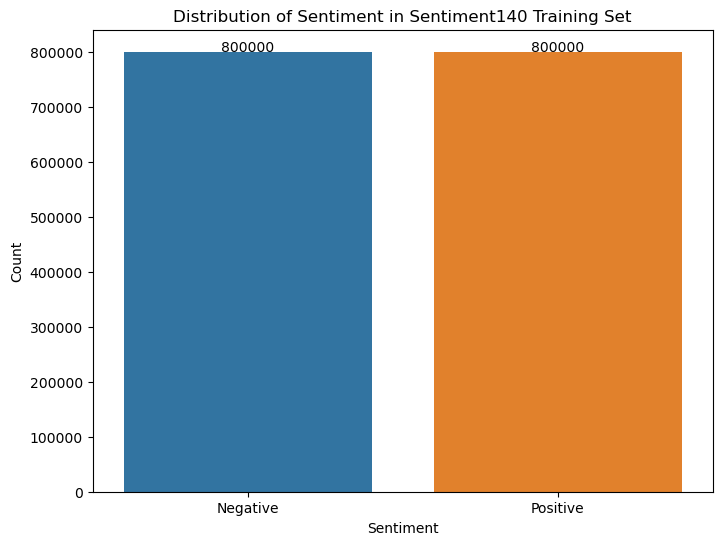

In [6]:
# SHOW SENTIMENT DISTRIBUTION IN TRAINING SET
distribution = df_train["target"].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title("Distribution of Sentiment in Sentiment140 Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative", "Positive"])

for i, v in enumerate(distribution.values):
    # ADD COUNTS ABOVE BARS
    plt.text(i, v, str(v), ha="center")

plt.show()

 ### Word Cloud

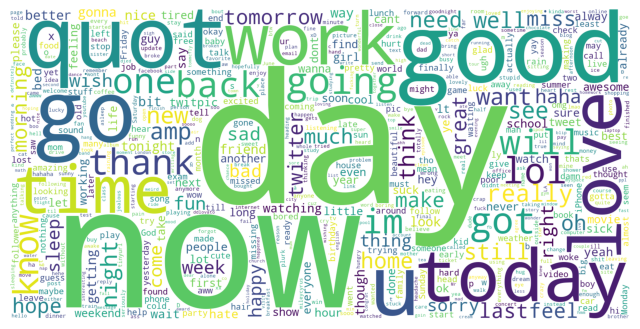

In [7]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    min_font_size=10,
    max_words=1000,
    collocations=False,
)

wordcloud.generate(" ".join(df_train["text"].tolist()))

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

 ## Preprocessing

 Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

 Preprocessing steps include:

 * Lower Casing: Each text is converted to lowercase.
 * Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
 * Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
 * Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
 * Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
 * Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
 * Removing Short Words: Words with length less than 2 are removed.
 * Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
 * Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: "Great" to "Good")

In [8]:
# SELECT COLUMNS OF INTEREST
df_train = df_train[["text", "target"]]

# REMAP SENTIMENT LABELS: 0 = negative, 1 = positive (instead of 0 = negative, 4 = positive)
df_train["target"] = df_train["target"].replace(4, 1)

In [9]:
BRANDS = [
    "google",
    "facebook",
    "microsoft",
    "amazon",
    "apple",
    "walmart",
    "nike",
    "target",
    "starbucks",
    "mcdonalds",
    "netflix",
    "disney",
    "zara",
    "adidas",
    "gucci",
    "verizon",
    "sony",
]

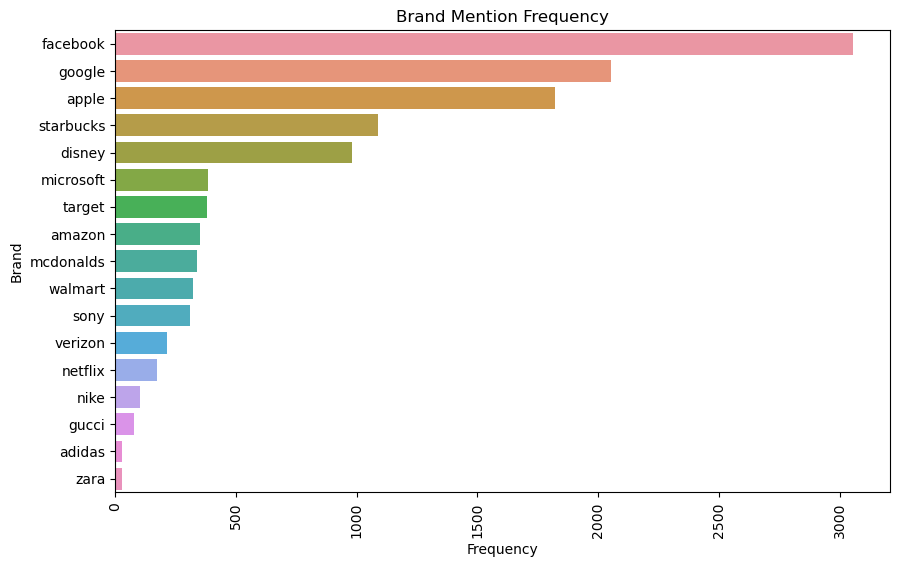

In [10]:
# VISUALIZE BRAND MENTION FREQUENCY
from collections import Counter

counter = Counter(
    word
    for tweet in df_train["text"]
    for word in tweet.lower().split()
    if word in BRANDS
)

brand_freqs_df = pd.DataFrame(
    counter.items(), columns=["Brand", "Frequency"]
).sort_values("Frequency", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Frequency", y="Brand", data=brand_freqs_df, order=brand_freqs_df["Brand"]
)
plt.xticks(rotation=90)
plt.title("Brand Mention Frequency")
plt.show()

In [11]:
brand_rows = []
for tweet in df_train["text"]:
    # TOKENIZE EACH TWEET, REMOVE HYPHENS, AND CONVERT ALL WORDS TO LOWERCASE
    tweet_tokens = {word.replace("-", "") for word in tweet.lower().split()}
    # FIND THE INTERSECTION OF TOKENIZED TWEETS AND BRANDS
    brands_in_tweet = tweet_tokens.intersection(BRANDS)
    if brands_in_tweet:
        for brand in brands_in_tweet:
            # APPEND A DICTIONARY WITH TWEET TEXT, BRAND PRESENCE FLAG, AND BRAND NAME TO THE LIST
            brand_rows.append({"tweet": tweet, "brand-presence": 1, "brand": brand})
    else:
        # APPEND A DICTIONARY WITH TWEET TEXT, BRAND PRESENCE FLAG, AND "NOBRAND" TO THE LIST
        brand_rows.append({"tweet": tweet, "brand-presence": 0, "brand": "nobrand"})

# CONVERT THE LIST OF DICTIONARIES INTO A PANDAS DATAFRAME
brands_df = pd.DataFrame(brand_rows)

# PRINT THE FIRST FEW ROWS OF THE DATAFRAME
print(brands_df.head())

                                                                             tweet  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda g...   
1  is upset that he can't update his Facebook by texting it... and might cry as...   
2  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go ...   
3                                  my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...   

   brand-presence     brand  
0               0   nobrand  
1               1  facebook  
2               0   nobrand  
3               0   nobrand  
4               0   nobrand  


In [12]:
# OUTPUT DATASET TO FILE
print(len(brands_df))
brands_df.to_csv("datasets/brands.csv", index=False)

1600081


In [13]:
# DEFINE PARAMETERS FOR DATA GENERATION

MODEL = "gpt-4"

DATASET_SIZE = 10

USER_PROMPT = f"""
    Create some data in the format:

    "tweet"|||brand-presence|||brand

    where:
        tweet is a Twitter post,
        brand-presence is 0 or 1 indicating presence or absence of a brand in the tweet, and
        brand is a brand named in this list: {str(BRANDS)} or nobrand when brand is 0.

    EXAMPLES:
        "@ashman01 My only complaint about Facebook is they've changed it so much it's confusing"|||1|||facebook
        "@juliet I ate some grapes yesterday and I loved them."|||0|||nobrand

    There should be an equal number of tweets with a brand (1) and tweets with no brand (0).

    Create {DATASET_SIZE} data points.
    """

In [14]:
import openai

openai.api_key = os.environ["OPENAI_API_KEY"]

# GENERATE DATA USING OPENAI'S GPT-4 MODEL
chat_completion = openai.ChatCompletion.create(
    model=MODEL,
    temperature=0,
    messages=[
        {"role": "user", "content": USER_PROMPT},
    ],
)

raw_chat_completion = chat_completion.choices[0].message.content
print(json.dumps(raw_chat_completion.split("\n"), indent=4))

[
    "\"@jameson I just bought a new pair of Nike shoes, they're so comfortable!\"|||1|||nike",
    "\"@lucy I can't believe how sunny it is today, perfect for a walk in the park.\"|||0|||nobrand",
    "\"@mike Just watched the latest Netflix series, it's amazing!\"|||1|||netflix",
    "\"@sarah I'm thinking about adopting a cat, they're so cute!\"|||0|||nobrand",
    "\"@peter I'm so impressed with the new iPhone, Apple really outdid themselves this time.\"|||1|||apple",
    "\"@emily I just finished reading a great book, I couldn't put it down.\"|||0|||nobrand",
    "\"@john I can't get enough of Starbucks coffee, it's the best!\"|||1|||starbucks",
    "\"@lisa I'm so excited for the weekend, I'm going to the beach.\"|||0|||nobrand",
    "\"@tom I just got a new Sony TV, the picture quality is incredible!\"|||1|||sony",
    "\"@rachel I love going to the farmers market on Sundays, the produce is so fresh.\"|||0|||nobrand"
]


In [15]:
# PROCESS RAW CONTENT BY SPLITTING IT INTO tweet, brand-presence, AND brand
processed_content = [
    {"tweet": content[0], "brand-presence": int(content[1]), "brand": content[2]}
    for content in (s.split("|||") for s in raw_chat_completion.split("\n"))
]

# PRETTY PRINT PROCESSED CONTENT
print(json.dumps(processed_content, indent=4))

# ADD TO brands_df DATAFRAME
processed_content_df = pd.DataFrame(processed_content)
brands_df = pd.concat([brands_df, processed_content_df], ignore_index=True)

[
    {
        "tweet": "\"@jameson I just bought a new pair of Nike shoes, they're so comfortable!\"",
        "brand-presence": 1,
        "brand": "nike"
    },
    {
        "tweet": "\"@lucy I can't believe how sunny it is today, perfect for a walk in the park.\"",
        "brand-presence": 0,
        "brand": "nobrand"
    },
    {
        "tweet": "\"@mike Just watched the latest Netflix series, it's amazing!\"",
        "brand-presence": 1,
        "brand": "netflix"
    },
    {
        "tweet": "\"@sarah I'm thinking about adopting a cat, they're so cute!\"",
        "brand-presence": 0,
        "brand": "nobrand"
    },
    {
        "tweet": "\"@peter I'm so impressed with the new iPhone, Apple really outdid themselves this time.\"",
        "brand-presence": 1,
        "brand": "apple"
    },
    {
        "tweet": "\"@emily I just finished reading a great book, I couldn't put it down.\"",
        "brand-presence": 0,
        "brand": "nobrand"
    },
    {
        "tweet

In [16]:
print(f"brands_df.shape: {brands_df.shape}")

brands_df.shape: (1600091, 3)


In [17]:
print(f"brands_df.brand.value_counts(): {brands_df.brand.value_counts()}")

brands_df.brand.value_counts(): brand
nobrand      1588498
facebook        3020
google          1983
apple           1779
starbucks       1080
disney           962
walmart          400
microsoft        385
target           377
amazon           345
mcdonalds        339
sony             306
verizon          211
netflix          175
nike             101
gucci             74
adidas            29
zara              27
Name: count, dtype: int64


In [18]:
print(f"brands_df.tail(6): \n{brands_df.tail(6)}")

brands_df.tail(6): 
                                                                                   tweet  \
1600085  "@peter I'm so impressed with the new iPhone, Apple really outdid themselves...   
1600086           "@emily I just finished reading a great book, I couldn't put it down."   
1600087                   "@john I can't get enough of Starbucks coffee, it's the best!"   
1600088                  "@lisa I'm so excited for the weekend, I'm going to the beach."   
1600089              "@tom I just got a new Sony TV, the picture quality is incredible!"   
1600090  "@rachel I love going to the farmers market on Sundays, the produce is so fr...   

         brand-presence      brand  
1600085               1      apple  
1600086               0    nobrand  
1600087               1  starbucks  
1600088               0    nobrand  
1600089               1       sony  
1600090               0    nobrand  


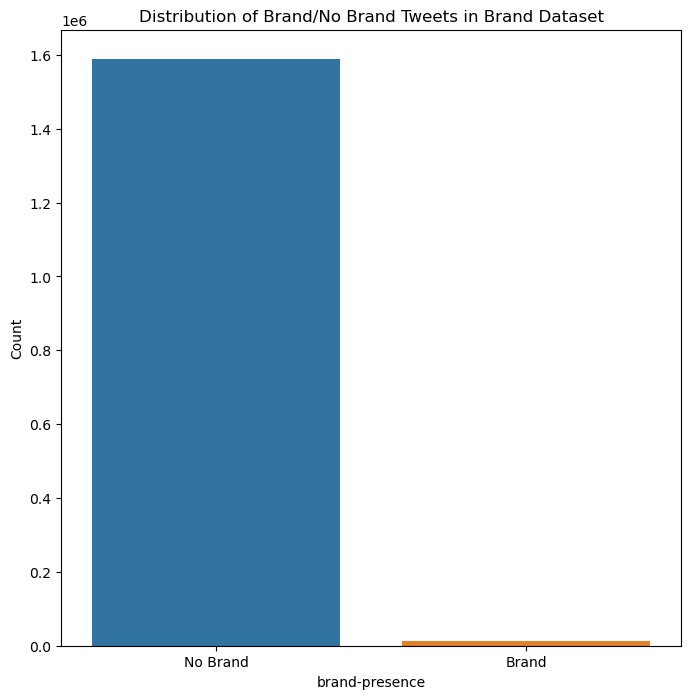

In [19]:
plt.figure(figsize=(8, 8))
sns.countplot(x="brand-presence", data=brands_df)
plt.title("Distribution of Brand/No Brand Tweets in Brand Dataset")
plt.ylabel("Count")
plt.xticks([0, 1], ["No Brand", "Brand"])
plt.show()

## Initializing NLTK for Text Processing

In this section, we initialize the Natural Language Toolkit (`nltk`), a robust Python library for processing human language data. It offers tools for various tasks including classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

Key components from `nltk` are downloaded, which include a tokenizer, a part-of-speech tagger, a named entity chunker, a corpus of words, a multilingual lexical database, and a corpus of stopwords.

The tokenizer facilitates the breakdown of text into sentences or words, the part-of-speech tagger assigns parts of speech to individual words, and the named entity chunker identifies named entities within the text.

The corpus of words and the multilingual lexical database are versatile tools that can be utilized for tasks such as spellchecking or language identification.

The stopwords corpus contains a list of common words, known as "stop words", in several languages, including English. These words, often filtered out during text processing, typically do not carry significant meaning.

We generate a set of English stop words to expedite membership checking. This set will be used in subsequent stages of the text processing pipeline to filter out these stop words from the text data.

In [28]:
import nltk
from nltk.corpus import stopwords

# PUNKT TOKENIZER FOR SENTENCE TOKENIZATION
nltk.download("punkt", quiet=True)

# TAGGER FOR PART-OF-SPEECH TAGGING
nltk.download("averaged_perceptron_tagger", quiet=True)

# CHUNKER FOR NAMED ENTITY RECOGNITION
nltk.download("maxent_ne_chunker", quiet=True)

# CORPUS OF WORDS FOR SPELLCHECKING OR LANGUAGE IDENTIFICATION
nltk.download("words", quiet=True)

# MULTILINGUAL LEXICAL DATABASE
nltk.download("omw-1.4", quiet=True)

# DOWNLOAD STOPWORDS CORPUS
nltk.download("stopwords", quiet=True)

# CREATE SET OF ENGLISH STOPWORDS FOR FASTER MEMBERSHIP CHECKING
STOP_WORDS = set(stopwords.words("english"))

In [21]:
import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import string

# REMOVE URLS AND @MENTIONS
p.set_options(p.OPT.URL, p.OPT.MENTION)

tweet_tokenizer = TweetTokenizer()
stemmer = PorterStemmer()


def preprocess(tweet):
    cleaned = p.clean(tweet)
    tokens = tweet_tokenizer.tokenize(cleaned)
    # REMOVE STOPWORDS AND PUNCTUATION
    filtered = [
        word
        for word in tokens
        if not word in STOP_WORDS and not word in string.punctuation
    ]
    # APPLY STEMMING
    stemmed = [stemmer.stem(word) for word in filtered]
    return stemmed


# SHOW SAMPLE TWEETS
tweets_sample = df_train[df_train["target"] == 1].head()
for tweet in tweets_sample["text"]:
    print(f"Original: {tweet}")
    processed_tweet = preprocess(tweet)
    print(f"Processed: {processed_tweet}\n")

Original: I LOVE @Health4UandPets u guys r the best!! 
Processed: ['i', 'love', 'u', 'guy', 'r', 'best']

Original: im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
Processed: ['im', 'meet', 'one', 'besti', 'tonight', 'cant', 'wait', 'girl', 'talk']

Original: @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
Processed: ['thank', 'twitter', 'add', 'sunisa', 'i', 'got', 'meet', 'hin', 'show', 'dc', 'area', 'sweetheart']

Original: Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup
Processed: ['be', 'sick', 'realli', 'cheap', 'hurt', 'much', 'eat', 'real', 'food', 'plu', 'friend', 'make', 'soup']

Original: @LovesBrooklyn2 he has that effect on everyone 
Processed: ['effect', 'everyon']



In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

vectorizer = CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(
    brands_df["tweet"], brands_df["brand"], test_size=0.2, random_state=42
)

In [23]:
from sklearn.naive_bayes import MultinomialNB

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

MultinomialNB()

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = clf.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9925723160187364
[[     0      0      0      0      0      0      0      0      0      0
       0      8      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0     70      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0    346      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0    200      0      0      0      0      0      0]
 [     0      0      0      0      1      0      0      0      0      0
       0    578      0      0      0      0      0      0]
 [     0      0      0      0      0      3      0      0      0      0
       0    379      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0     20      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0   

In [25]:
# ABOUTNESS PROBLEM
test_tweets = [
    "I love to ride my bike",
    "I hate eating apples",
    "Did you google that?",
    "Hello world",
]

tweets_vectorized = vectorizer.transform(test_tweets)

out = clf.predict(tweets_vectorized)

print(out)

['nobrand' 'nobrand' 'nobrand' 'nobrand']


In [26]:
# FILL MISSING VALUES IN 'brand' WITH 'NoBrand'
brands_df["brand"].fillna("NoBrand", inplace=True)

# INITIALIZING CountVectorizer (AKA BAG OF WORDS)
vectorizer = CountVectorizer()

# SPLIT DATA INTO TRAIN AND TEST SETS, 20% DATA IS USED FOR TESTING
X_train, X_test, y_train, y_test = train_test_split(
    brands_df["tweet"], brands_df["brand"], test_size=0.2, random_state=42
)

# TRANSFORM TWEETS INTO NUMERICAL FEATURE VECTORS USING CountVectorizer
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [29]:
from datetime import datetime
import wandb
from wandb.keras import WandbCallback

wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: Currently logged in as: jagustin (subsystem3). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


True

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import joblib

# INITIALIZE A NEW W&B RUN
now = datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
run = wandb.init(
    project="brand-sentiment-analyzer", name=f"{timestamp_str}_logistic_regression"
)

# DEFINE A LOGISTIC REGRESSION MODEL
log_reg_model = LogisticRegression()

# FIT THE MODEL TO THE TRAINING DATA
log_reg_model.fit(X_train_vectorized, y_train)

# SAVE THE TRAINED MODEL
if not os.path.exists("models"):
    os.makedirs("models")
model_path = "model.pkl"
joblib.dump(log_reg_model, model_path)

# PREDICT ON THE TEST DATA
y_pred = log_reg_model.predict(X_test_vectorized)

# CALCULATE ACCURACY
accuracy = accuracy_score(y_test, y_pred)

# LOG ACCURACY TO W&B
wandb.log({"Accuracy": accuracy})

# SAVE MODEL AS ARTIFACT IN W&B
artifact = wandb.Artifact("model-logistic_regression", type="model")
artifact.add_file(model_path)
run.log_artifact(artifact)

# PRINT CLASSIFICATION REPORT
print(classification_report(y_test, y_pred, zero_division=0))

# FINISH THE W&B RUN
run.finish()

/home/user/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      adidas       0.00      0.00      0.00         8
      amazon       0.74      0.84      0.79        70
       apple       0.82      0.86      0.84       346
      disney       0.87      0.93      0.90       200
    facebook       0.71      0.82      0.76       579
      google       0.84      0.91      0.87       382
       gucci       0.79      0.55      0.65        20
   mcdonalds       0.82      0.76      0.79        72
   microsoft       0.77      0.68      0.72        93
     netflix       0.66      0.61      0.63        38
        nike       0.73      0.35      0.47        23
     nobrand       1.00      1.00      1.00    317688
        sony       0.75      0.87      0.81        60
   starbucks       0.77      0.85      0.81       237
      target       0.73      0.83      0.78        70
     verizon       0.82      0.82      0.82        38
     walmart       0.72      0.73      0.72        91
        zara       0.00    

Accuracy,▁
Accuracy,0.99714


In [31]:
# DEFINE TRANSFORMERS MODEL
import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [32]:
# TOKENIZE TWEETS
sample_txt = brands_df["tweet"][0]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f" Sentence: {sample_txt}")
print(f"   Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

 Sentence: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
   Tokens: ['@', 'switch', '##foot', 'http', ':', '/', '/', 't', '##wi', '##t', '##pic', '.', 'com', '/', '2', '##y', '##1', '##z', '##l', '-', 'A', '##w', '##w', '##w', ',', 'that', "'", 's', 'a', 'b', '##um', '##mer', '.', 'You', 'should', '##a', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', '.', ';', 'D']
Token IDs: [137, 6878, 10744, 8413, 131, 120, 120, 189, 10073, 1204, 20437, 119, 3254, 120, 123, 1183, 1475, 1584, 1233, 118, 138, 2246, 2246, 2246, 117, 1115, 112, 188, 170, 171, 1818, 4027, 119, 1192, 1431, 1161, 1400, 1681, 12639, 1104, 4180, 2295, 1106, 1202, 1122, 119, 132, 141]


In [33]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


# DEFINE PYTORCH DATASET
class BrandDataset(Dataset):
    def __init__(self, tweets, brands, tokenizer, max_len):
        self.tweets = tweets
        self.brands = brands
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        brand = self.brands[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "tweet_text": tweet,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "brands": torch.tensor(brand, dtype=torch.long),
        }

In [34]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
brands_df["brand_encoded"] = encoder.fit_transform(brands_df["brand"])

In [35]:
# CREATE DATA LOADERS
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = BrandDataset(
        tweets=df["tweet"].to_numpy(),
        brands=df["brand_encoded"].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=4)


BATCH_SIZE = 16
MAX_LEN = 160

train_data_loader = create_data_loader(brands_df, tokenizer, MAX_LEN, BATCH_SIZE)

/home/user/anaconda3/envs/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [36]:
# DEFINE THE MODEL ARCHITECTURE
class BrandClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BrandClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [37]:
# CREATE THE MODEL INSTANCE
N_CLASSES = len(brands_df["brand"].unique())
model = BrandClassifier(N_CLASSES)
model = model.to(device)

In [38]:
# TRAIN THE MODEL
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/user/anaconda3/envs/venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
# DEFINE THE TRAINING FUNCTION
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        brands = d["brands"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, brands)

        correct_predictions += torch.sum(preds == brands)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
# TRAIN THE MODEL
from collections import defaultdict

# INITIALIZE A NEW W&B RUN
now = datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
run = wandb.init(
    project="brand-sentiment-analyzer", name=f"{timestamp_str}_llm_train_epoch"
)

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(brands_df)
    )

    # LOG THE LOSS AND ACCURACY TO W&B
    wandb.log({"Train Loss": train_loss, "Train Accuracy": train_acc})

    print(f"Train loss {train_loss} accuracy {train_acc}")

    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)

    if train_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = train_acc

# FINISH THE W&B RUN
run.finish()

Epoch 1/10
----------


/home/user/anaconda3/envs/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/user/anaconda3/envs/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to

TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str

In [ ]:
# PLOT TRAINING ACCURACY AND LOSS
plt.plot(history["train_acc"], label="train accuracy")
plt.title("Training history")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.ylim([0, 1])
plt.show()

: 

In [ ]:
# LOAD BEST MODEL
model.load_state_dict(torch.load("best_model_state.bin"))

: 

In [ ]:
# SAMPLE PREDICTIONS
def get_predictions(model, data_loader):
    model = model.eval()

    tweet_texts = []
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    return tweet_texts, predictions, prediction_probs

: 

In [ ]:
y_tweet_texts, y_pred, y_pred_probs = get_predictions(model, train_data_loader)

: 

In [ ]:
# PRINT SAMPLE PREDICTIONS
for i in range(5):
    print(f"Tweet: {y_tweet_texts[i]}")
    print(f"Brand: {encoder.inverse_transform([y_pred[i]])[0]}")
    print()

: 

In [ ]:
# LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# PREPARE DATA FOR LSTM
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(brands_df["tweet"].values)

X = tokenizer.texts_to_sequences(brands_df["tweet"].values)
X = pad_sequences(X)  # padding our text vector so they all have the same length
y = pd.get_dummies(brands_df["brand"]).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# DEFINE LSTM MODEL
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(N_CLASSES, activation="softmax"))

# COMPILE MODEL
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# TRAIN MODEL
earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3, verbose=0, mode="auto"
)
model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[earlystop],
)

# EVALUATE MODEL
score, acc = model.evaluate(X_test, y_test, verbose=2, batch_size=BATCH_SIZE)
print(f"Score: {score}")
print(f"Validation Accuracy: {acc}")

: 